In [161]:
from char_extraction import plot_list, get_line_boxes, get_lines, get_words
import matplotlib.pyplot as plt
import cv2
import numpy as np
from math import floor, ceil
from statistics import mode

In [228]:
test_img = cv2.imread('testimg13.jpg', cv2.IMREAD_GRAYSCALE)

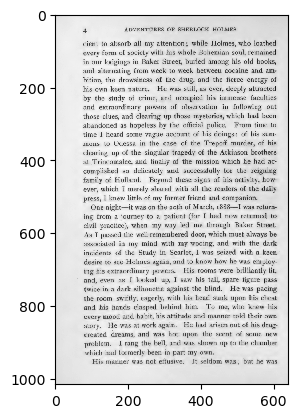

In [229]:
# image preview
plt.imshow(test_img, cmap='gray')
plt.show()

In [164]:
# try different params
def get_adaptive_line_boxes(img):
    line_dilation_kernel_sizes = [3, 5, 7, 9, 11, 13, 15]

    all_num_lines = []
    best_stddev = None
    best_kernel = None
    best_num_lines = None
    for l in line_dilation_kernel_sizes:
        print(f'line dilation kernel: ({l}, 1)')
        lines, thresh, dilate, _, contours = get_line_boxes(img, DILATION_KERNEL_SIZE=(l,1))
        lines = get_lines(img, contours)
        num_lines = len(lines)
        print(f'num lines: {num_lines}')
        all_num_lines.append(num_lines)
        
        heights = []
        for line in lines:
            s = line.shape
            heights.append(s[0])
        print(f'avg line height: {np.mean(heights)}')
        print(f'median line height: {np.median(heights)}')
        stddev = np.std(heights)
        print(f'std dev line height: {stddev}')
        if best_stddev is None:
            best_stddev = stddev
            best_kernel = l
            best_num_lines = num_lines
        elif stddev <= best_stddev: # take the smallest stddev in line height
            best_stddev = stddev
            best_kernel = l
            best_num_lines = num_lines


        plt.figure(figsize=(2,2))
        plt.hist(heights)
        plt.show()
            
        print()
        
    # find the best one
    med = np.median(all_num_lines)
    # mod = mode(all_num_lines)
    mod = max(all_num_lines, key = all_num_lines.count)
    
    if 0.9*med <= best_num_lines <= 1.1*med or 0.9*mod <= best_num_lines <= 1.1*mod:
        print(f'best found! kernel: ({best_kernel}, 1)')
        lines, thr, dil, img_w_boxes, contours = get_line_boxes(img, DILATION_KERNEL_SIZE=(best_kernel,1))
        return lines, thr, dil, img_w_boxes, contours
    else:
        print(f'incongruence: best kernel ({best_kernel}, 1) has {best_num_lines}, median is {np.median(all_num_lines)}')

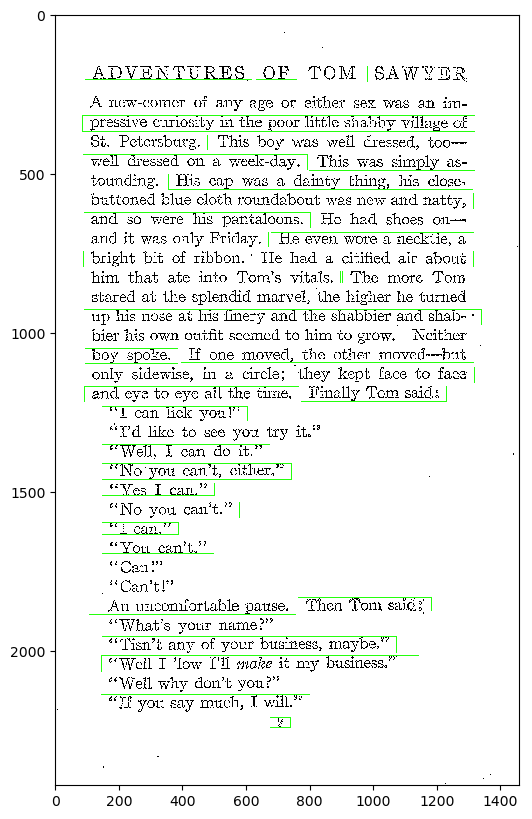

In [174]:
lines, thresh, dilate, image_with_boxes, contours = get_line_boxes(test_img,
                                                                   DILATION_KERNEL_SIZE=(13,1),
                                                                  GAUSSIAN_BLUR_KERNEL=(5,5),
                                                                  THRESH_TUNE=3,
                                                                  THRESH_NEIGHBORHOOD_SIZE=3)
plt.figure(figsize=(20,10))
plt.imshow(image_with_boxes, cmap='gray') # or thresh or dilate
plt.show()

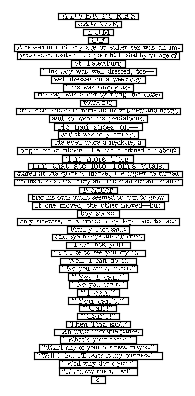

In [175]:
plot_list(lines)

line dilation kernel: (3, 1)
num lines: 117
avg line height: 17.53846153846154
median line height: 18.0
std dev line height: 2.7996900363795203


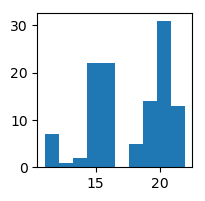


line dilation kernel: (5, 1)
num lines: 47
avg line height: 20.21276595744681
median line height: 21.0
std dev line height: 2.009934583594816


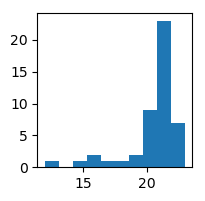


line dilation kernel: (7, 1)
num lines: 38
avg line height: 20.789473684210527
median line height: 21.0
std dev line height: 1.7793833162502068


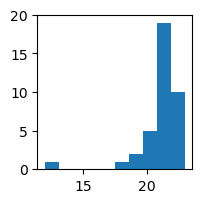


line dilation kernel: (9, 1)
num lines: 37
avg line height: 20.864864864864863
median line height: 21.0
std dev line height: 1.742352590409319


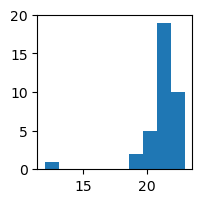


line dilation kernel: (11, 1)
num lines: 37
avg line height: 20.864864864864863
median line height: 21.0
std dev line height: 1.742352590409319


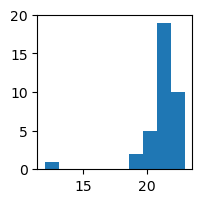


line dilation kernel: (13, 1)
num lines: 38
avg line height: 20.710526315789473
median line height: 21.0
std dev line height: 2.0379026206894046


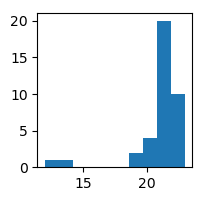


line dilation kernel: (15, 1)
num lines: 38
avg line height: 20.710526315789473
median line height: 21.0
std dev line height: 2.0379026206894046


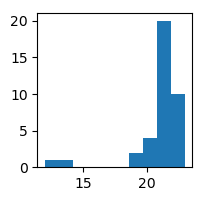


best found! kernel: (11, 1)


In [230]:
lines, thresh, dilate, image_with_boxes, contours = get_adaptive_line_boxes(test_img)

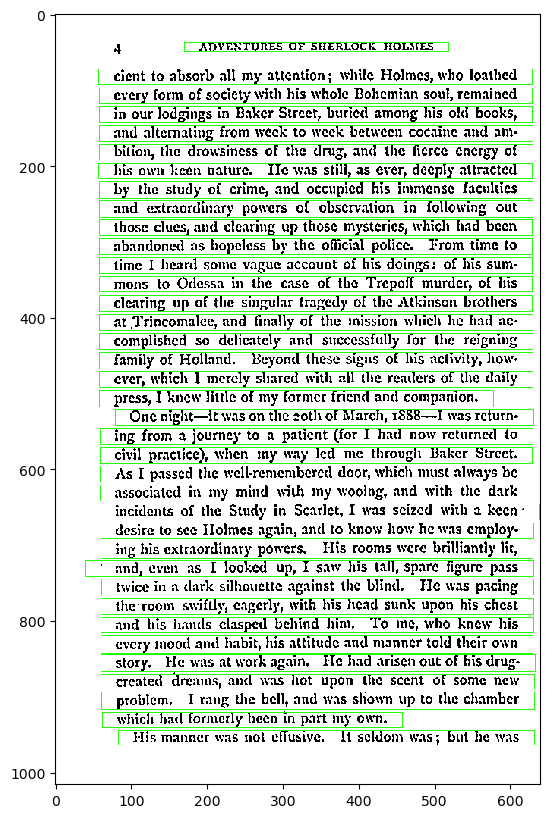

In [231]:
plt.figure(figsize=(20,10))
plt.imshow(image_with_boxes, cmap='gray') # or thresh or dilate
plt.show()

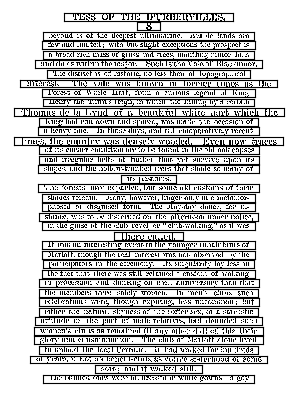

In [226]:
plot_list(lines)

In [220]:
def get_adaptive_words(lines_of_page):
    word_dilation_kernel_sizes = [3, 4, 5, 6]

    best_stddev = None
    best_kernel = None
    best_num_lines = None
    for w1 in word_dilation_kernel_sizes:
            for w2 in word_dilation_kernel_sizes: 
                print(f'word dilation kernel: ({w1}, {w2})')
                all_words = []
                heights = []
                widths = []
                for line in lines_of_page:
                    word_list, thresh, _, dilate = get_words(line, WORD_DILATION_KERNEL_SIZE=(w1, w2))
                    all_words.extend(word_list)
                    heights.extend([w.shape[0] for w in word_list])
                    widths.extend([w.shape[1] for w in word_list])
                    
                ratios = [i/j for i,j in zip(widths, heights)]
                num_bad_ratio = np.count_nonzero([r < 1.5 for r in ratios])
                    
                print(f'num words: {len(all_words)}')
                print(f'proportion bad ratio: {num_bad_ratio/len(all_words)*100: .2f}%')
                print(f'avg word height: {np.mean(heights)}')
                print(f'median word height: {np.median(heights)}')
                print(f'avg word width: {np.mean(widths)}')
                print(f'median word width: {np.median(widths)}')
                stddev_h = np.std(heights)
                stddev_w = np.std(widths)
                print(f'std dev word height: {stddev_h}')
                print(f'std dev word width: {stddev_w}')

                if best_stddev is None:
                    best_stddev = stddev_h
                    best_kernel = (w1, w2)
                elif stddev_h <= best_stddev: # take the smallest stddev in line height
                    best_stddev = stddev_h
                    best_kernel = (w1, w2)


                plt.figure(figsize=(2,2))
                plt.hist(heights)
                plt.show()

                print()
    print(f'best kernel: {best_kernel}')
    all_words = []
    for line in lines_of_page:
        word_list, _, _, _ = get_words(line, WORD_DILATION_KERNEL_SIZE=best_kernel)
        all_words.extend(word_list)
    return all_words

word dilation kernel: (3, 3)
num words: 427
proportion bad ratio:  24.12%
avg word height: 16.318501170960186
median word height: 17.0
avg word width: 39.039812646370024
median word width: 34.0
std dev word height: 3.0417407813089175
std dev word width: 22.09646316209977


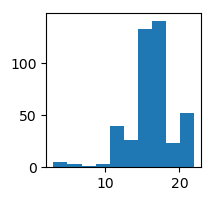


word dilation kernel: (3, 4)
num words: 417
proportion bad ratio:  25.66%
avg word height: 17.22062350119904
median word height: 17.0
avg word width: 39.935251798561154
median word width: 35.0
std dev word height: 2.806169392892376
std dev word width: 22.203616908816453


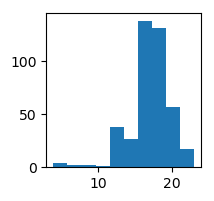


word dilation kernel: (3, 5)
num words: 409
proportion bad ratio:  25.67%
avg word height: 17.757946210268948
median word height: 18.0
avg word width: 40.687041564792175
median word width: 36.0
std dev word height: 2.4827210577121623
std dev word width: 22.073446045939807


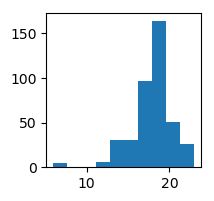


word dilation kernel: (3, 6)
num words: 407
proportion bad ratio:  30.96%
avg word height: 18.493857493857494
median word height: 19.0
avg word width: 40.88697788697789
median word width: 37.0
std dev word height: 2.3248125568332263
std dev word width: 22.045675222740126


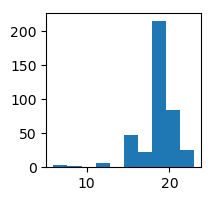


word dilation kernel: (4, 3)
num words: 397
proportion bad ratio:  18.39%
avg word height: 16.604534005037785
median word height: 17.0
avg word width: 42.949622166246854
median word width: 38.0
std dev word height: 2.854538936682261
std dev word width: 22.180788680908435


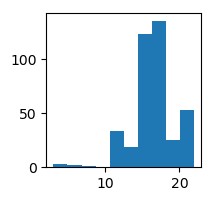


word dilation kernel: (4, 4)
num words: 395
proportion bad ratio:  19.24%
avg word height: 17.475949367088607
median word height: 18.0
avg word width: 43.13670886075949
median word width: 39.0
std dev word height: 2.534082371548079
std dev word width: 22.080096869714986


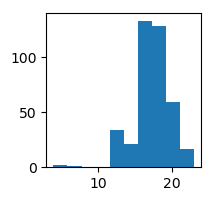


word dilation kernel: (4, 5)
num words: 394
proportion bad ratio:  20.56%
avg word height: 17.913705583756347
median word height: 18.0
avg word width: 43.233502538071065
median word width: 39.0
std dev word height: 2.271577857807321
std dev word width: 22.024243550594008


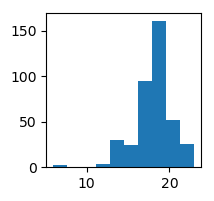


word dilation kernel: (4, 6)
num words: 394
proportion bad ratio:  24.11%
avg word height: 18.63705583756345
median word height: 19.0
avg word width: 43.233502538071065
median word width: 39.0
std dev word height: 2.070520045988823
std dev word width: 22.024243550594008


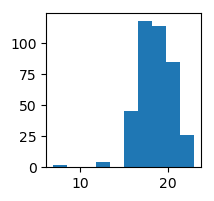


word dilation kernel: (5, 3)
num words: 394
proportion bad ratio:  17.26%
avg word height: 16.6751269035533
median word height: 17.0
avg word width: 44.25126903553299
median word width: 39.5
std dev word height: 2.707582998645727
std dev word width: 22.28029360581055


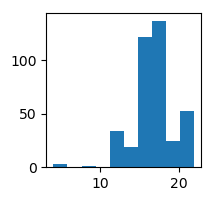


word dilation kernel: (5, 4)
num words: 393
proportion bad ratio:  17.81%
avg word height: 17.513994910941477
median word height: 18.0
avg word width: 44.346055979643765
median word width: 40.0
std dev word height: 2.4475012068914115
std dev word width: 22.229140743293733


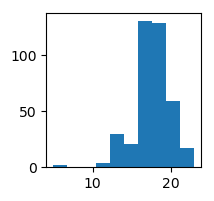


word dilation kernel: (5, 5)
num words: 393
proportion bad ratio:  18.83%
avg word height: 17.916030534351144
median word height: 18.0
avg word width: 44.346055979643765
median word width: 40.0
std dev word height: 2.2739978401891023
std dev word width: 22.229140743293733


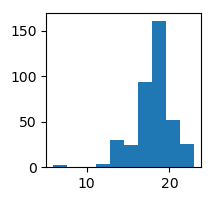


word dilation kernel: (5, 6)
num words: 393
proportion bad ratio:  21.88%
avg word height: 18.638676844783713
median word height: 19.0
avg word width: 44.346055979643765
median word width: 40.0
std dev word height: 2.0729029146429125
std dev word width: 22.229140743293733


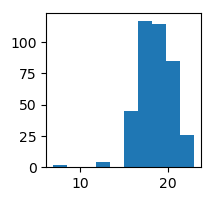


word dilation kernel: (6, 3)
num words: 388
proportion bad ratio:  15.46%
avg word height: 16.77061855670103
median word height: 17.0
avg word width: 45.93041237113402
median word width: 41.0
std dev word height: 2.6176369742055168
std dev word width: 22.90495383403399


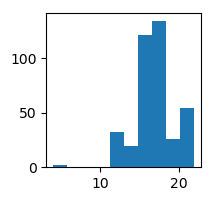


word dilation kernel: (6, 4)
num words: 388
proportion bad ratio:  17.53%
avg word height: 17.561855670103093
median word height: 18.0
avg word width: 45.93041237113402
median word width: 41.0
std dev word height: 2.448182296416766
std dev word width: 22.90495383403399


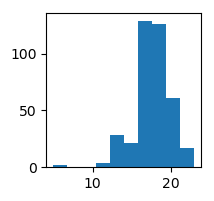


word dilation kernel: (6, 5)
num words: 388
proportion bad ratio:  18.04%
avg word height: 17.95618556701031
median word height: 18.0
avg word width: 45.93041237113402
median word width: 41.0
std dev word height: 2.2773283964678215
std dev word width: 22.90495383403399


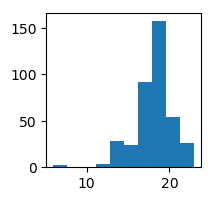


word dilation kernel: (6, 6)
num words: 388
proportion bad ratio:  19.07%
avg word height: 18.675257731958762
median word height: 19.0
avg word width: 45.93041237113402
median word width: 41.0
std dev word height: 2.0678456804888765
std dev word width: 22.90495383403399


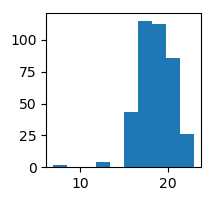


best kernel: (6, 6)


In [232]:
lines = get_lines(test_img, contours)
words = get_adaptive_words(lines)